# IREI: Profile-based retrieval
### Víctor Morcuende Castell and Guillermo Nájera Lavid
#### Course 2022-2023

### Preprocessing Phase

In [1]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]    | 

True

In [2]:
# Read the data
import pandas as pd

train_data = pd.read_csv('dataset/BBC News Train.csv')
test_data = pd.read_csv('dataset/BBC News Test.csv')

# Transform the data into a single dataset
data = pd.concat([train_data,test_data])
data.to_csv('dataset/data.csv', index=False)

# Remove duplicated data
data = data.drop_duplicates(subset=['Text','Category'])
data.head(10)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


In [3]:
data.shape

(2163, 3)

In [4]:
data.groupby(['Category']).size().sort_values(ascending=True)

Category
tech             375
entertainment    406
politics         412
business         481
sport            489
dtype: int64

<AxesSubplot:ylabel='Category'>

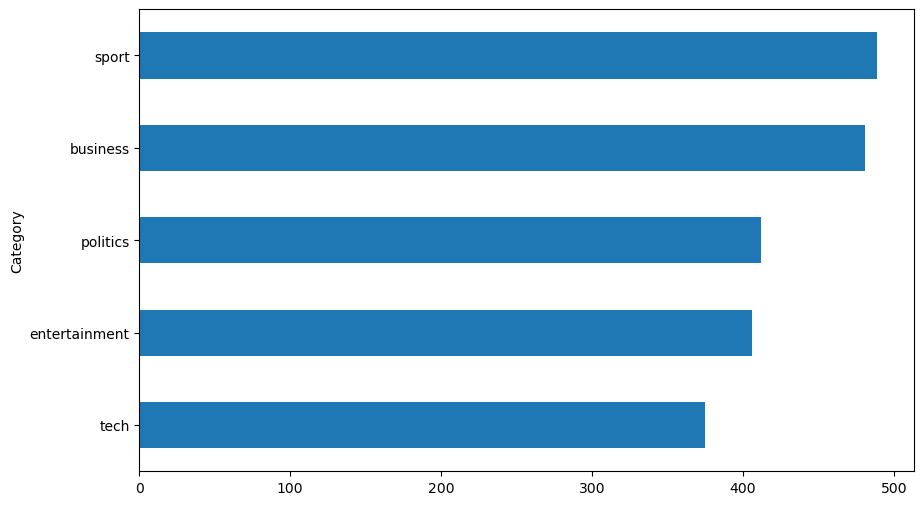

In [5]:
data.groupby(['Category']).size().sort_values(ascending=True).plot(kind='barh', figsize=(10, 6))

In [6]:
# Remove all punctuations from the text
import string as st

def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

data['removed_punc'] = data['Text'].apply(lambda x: remove_punct(x))
data.head()

,ArticleId,Text,Category,removed_punc
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...


In [7]:
# Convert text to lower case tokens
import re

def tokenize(text):
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]

data['tokens'] = data['removed_punc'].apply(lambda msg : tokenize(msg))
data.head()

,ArticleId,Text,Category,removed_punc,tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo..."


In [8]:
# Remove tokens of length less than 3
def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

data['larger_tokens'] = data['tokens'].apply(lambda x : remove_small_words(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former..."


In [9]:
# Remove stopwords by using NLTK corpus list
def remove_stopwords(text):
    return [word for word in text if word not in nltk.corpus.stopwords.words('english')]

data['clean_tokens'] = data['larger_tokens'].apply(lambda x : remove_stopwords(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former..."


In [10]:
# Apply lemmatization on tokens
from nltk import WordNetLemmatizer

def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

data['lemma_words'] = data['clean_tokens'].apply(lambda x : lemmatize(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens,lemma_words
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defence, lawyer, de..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slide, german, ..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizen, ma..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former...","[enron, boss, 168m, payout, eighteen, former, ..."


In [11]:
# Create sentences to get clean text as input for vectors
def return_sentences(tokens):
    return " ".join([word for word in tokens])

data['clean_text'] = data['lemma_words'].apply(lambda x : return_sentences(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens,lemma_words,clean_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defence, lawyer, de...",worldcom exboss launch defence lawyer defendin...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slide, german, ...",german business confidence slide german busine...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizen, ma...",poll indicates economic gloom citizen majority...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...",lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former...","[enron, boss, 168m, payout, eighteen, former, ...",enron boss 168m payout eighteen former enron d...


### Model and Evaluation Phase

In [12]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
# Balancing the dataset to have the same number of documents for each query
from sklearn.utils import resample

def balance_data(data, category_col):
    categories = data[category_col].unique()
    min_category_count = data[category_col].value_counts().min()

    balanced_data = []

    for category in categories:
        category_data = data[data[category_col] == category]
        category_data_balanced = resample(category_data, replace=False, n_samples=min_category_count, random_state=42)
        balanced_data.append(category_data_balanced)

    return pd.concat(balanced_data)

In [14]:
data = balance_data(data, 'Category')
balanced_data = data[['clean_text', 'Category']]
X_train, X_test, y_train, y_test = train_test_split(balanced_data['clean_text'], balanced_data['Category'], test_size=0.2, random_state=42)
balanced_data.groupby(['Category']).size().sort_values(ascending=True)

Category
business         375
entertainment    375
politics         375
sport            375
tech             375
dtype: int64

<AxesSubplot:ylabel='Category'>

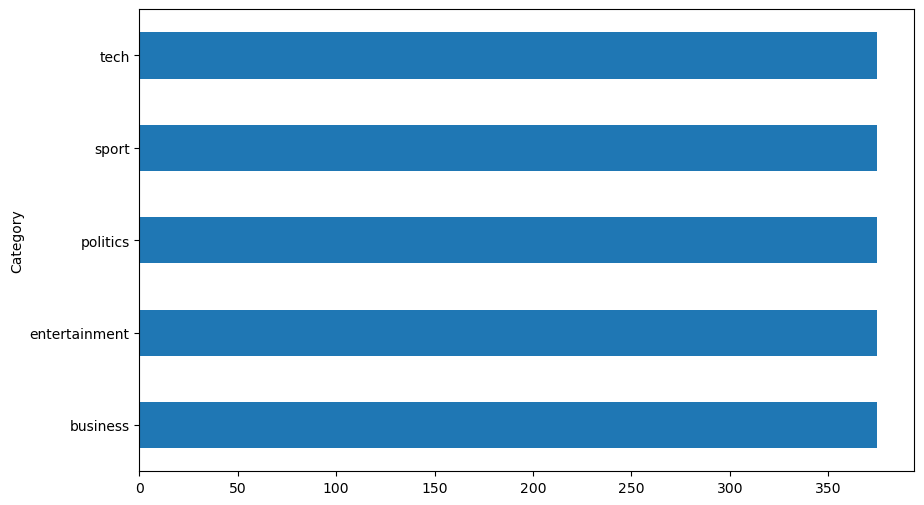

In [15]:
balanced_data.groupby(['Category']).size().sort_values(ascending=True).plot(kind='barh', figsize=(10, 6))

In [165]:
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=5)
#vectorizer = TfidfVectorizer(norm='l2', use_idf=False)
vectorizer = CountVectorizer()
document_vectors = vectorizer.fit_transform(balanced_data['clean_text'])

In [166]:
topics = {
    # Sports
    'sports': ["sports", "championship", "soccer", "race", "football", "tennis", "baseball", "hockey", 
               "basketball", "athletics", "rugby", "swimming", "golf", "cycling", "cricket", "marathon", 
               "gymnastics", "boxing", "volleyball", "badminton", "fencing", "wrestling", "snowboarding", 
               "skiing", "horse-racing", "archery", "table-tennis", "e-sports", "fitness", "olympics", 
               "martial-arts", "bobsleigh", "luge", "skeleton", "curling", "ultimate-frisbee", 
               "trampolining", "polo", "shinty", "hurling", "bowls", "lacrosse", "squash", "raquetball", 
               "pickleball", "korfball", "petanque", "orienteering", "diving", "synchronized-swimming"],
    
    # Business
    'business': ["business", "finance", "stocks", "economy", "investment", "entrepreneurship", "corporation", 
                 "market", "trade", "revenue", "profit", "startup", "loss", "growth", "acquisition", "tax", 
                 "debt", "funding", "venture", "capital", "inflation", "interest", "dividends", "corporate", 
                 "management", "banking", "insurance", "real-estate", "franchise", "supply-chain", "mergers", 
                 "initial-public-offering", "brand-awareness", "customer-service", "e-commerce", "wholesale", 
                 "leadership", "organizational-culture", "workforce-development", "sustainability", 
                 "foreign-exchange", "portfolio-management", "risk-management", "compliance", 
                 "corporate-social-responsibility", "benchmarking", "due-diligence", "cost-reduction", 
                 "cash-flow", "blue-ocean-strategy"],
    
    # Entertainment
    'entertainment': ["entertainment", "movies", "music", "television", "celebrities", "awards", "festivals", 
                      "concert", "theater", "comedy", "drama", "action", "romance", "animation", "documentary", 
                      "dance", "art", "literature", "photography", "sculpture", "painting", "opera", "magic", 
                      "circus", "museum", "exhibition", "actor", "actress", "singer", "culture", "improv", "mime", 
                      "cabaret", "burlesque", "ventriloquism", "orchestra", "symphony", "graphic-novels", 
                      "science-fiction", "fantasy", "horror", "mystery", "thriller", "audiobooks", "book-club", 
                      "fan-fiction", "short-films", "web-series", "sitcom", "reality-show"],
    
    # Politics
    'politics': ["politics", "government", "elections", "policy", "democracy", "president", "parliament", "vote", 
                 "prime-minister", "congress", "senate", "international", "relations", "diplomacy", "referendum", 
                 "constitution", "legislation", "political-party", "campaign", "debate", "rights", "protest", 
                 "activism", "military", "intelligence", "treaty", "embassy", "visa", "immigration", 
                 "trade-agreements", "grassroots-movement", "voting-rights", "redistricting", "gerrymandering", 
                 "bipartisanship", "state-government", "regional-politics", "environmental-policy", "tax-policy", 
                 "labor-relations", "housing-policy", "income-inequality", "social-welfare", "energy-policy", 
                 "security-policy", "deregulation", "non-governmental-organization", "international-organizations", 
                 "civil-society", "think-tank"],
    
    # Tech
    'tech': ["tech", "technology", "innovation", "gadgets", "smartphone", "artificial-intelligence", "robotics", 
             "software", "hardware", "computer", "internet", "cybersecurity", "virtual-reality", "augmented-reality", 
             "machine-learning", "data-science", "blockchain", "cryptocurrency", "internet-of-things", "cloud-computing", 
             "big-data", "quantum-computing", "networking", "operating-system", "mobile-apps", "programming", "research", 
             "drones", "3D-printing", "wearables", "genomics", "neural-networks", "microprocessor", "transistor", 
             "fiber-optics", "cyber-warfare", "cyber-physical-systems", "green-technology", "bio-inspired-computing", 
             "geographic-information-systems", "digital-twin", "high-performance-computing", "edge-computing", "algorithm", 
             "cryptology", "application-programming-interface", "data-visualization", "machine-ethics", 
             "information-security", "smart-grid"]
}

In [167]:
users = [
    {'id': 1, 'interests': ['sports']},
    {'id': 2, 'interests': ['business']},
    {'id': 3, 'interests': ['entertainment']},
    {'id': 4, 'interests': ['politics']},
    {'id': 5, 'interests': ['tech']},
    {'id': 6, 'interests': ['sports', 'business']},
    {'id': 7, 'interests': ['entertainment', 'politics']},
    {'id': 8, 'interests': ['tech', 'sports']},
    {'id': 9, 'interests': ['business', 'entertainment']},
    {'id': 10, 'interests': ['politics', 'tech', 'business']}
]

In [168]:
user_vectors = []
for user in users:
    interests = " ".join(user['interests'])
    vector = vectorizer.transform([interests])
    user_vectors.append(vector)

lista_vecs = [user_vectors[i] for i in range(len(user_vectors))]

In [169]:
lista_vecs2 = [user_vectors[i] for i in range(len(user_vectors))]
for user in lista_vecs2:
    print(user)


  (0, 4602)	1
  (0, 8768)	1
  (0, 18185)	1
  (0, 23450)	1
  (0, 4602)	1
  (0, 8768)	1
  (0, 18185)	1
  (0, 23450)	1
  (0, 4602)	1
  (0, 8768)	1
  (0, 4602)	1
  (0, 18185)	1
  (0, 23450)	1


In [170]:
predictions = []
predictions2 = []
for i in range(0, len(lista_vecs)):
    match = 0
    best_similarity = -1
    for j in range(0, document_vectors.shape[0]):
        document = document_vectors[j]
        similarity = cosine_similarity(document, lista_vecs[i])
        if similarity > best_similarity:
            best_similarity = similarity
            match = j
    predictions.append(balanced_data.iloc[match]['Category'])
    predictions2.append(balanced_data.iloc[match]['clean_text'])

for polla, user in zip(predictions, users):
    print(polla)
    print(user['interests'])


business
['sports']
politics
['business']
entertainment
['entertainment']
politics
['politics']
business
['tech']
politics
['sports', 'business']
politics
['entertainment', 'politics']
business
['tech', 'sports']
politics
['business', 'entertainment']
politics
['politics', 'tech', 'business']


In [ ]:
import random

for i in range(10):
  min_length = min(len(balanced_data['clean_text']), document_vectors.shape[0])
  random_index = random.randint(0, min_length - 1) 
  incoming_doc_vector = document_vectors[random_index]
  list_sim = []

  profiles = []

  for j in range(len(lista_vecs)):
    similarities = cosine_similarity(incoming_doc_vector, lista_vecs[j]) 
    if similarities[0][0] > 0.0:
      profiles.append(j+1)
      list_sim.append(similarities[0][0])
  
  print("For document",i+1, ":", balanced_data['clean_text'].iloc[random_index])
  print("Categorized as: "+ balanced_data['Category'].iloc[random_index]+ ' topic.')
  print("The user who are interested in this document are", profiles)
  print()

  print("RANKING")
  ranking = pd.DataFrame()
  ranking["Users"] = profiles
  ranking["Score"] = list_sim
  ranking = ranking.sort_values('Score', ascending=False)
  print(ranking)
  print()

In [ ]:
correct_predictions = 0
total_predictions = 10

for i in range(total_predictions):
    min_length = min(len(balanced_data['clean_text']), document_vectors.shape[0])
    random_index = random.randint(0, min_length - 1)
    incoming_doc_vector = document_vectors[random_index]
    list_sim = []

    profiles = []

    for j in range(len(lista_vecs)):
        similarities = cosine_similarity(incoming_doc_vector, lista_vecs[j])
        if similarities[0][0] > 0.0:
            profiles.append(j + 1)
            list_sim.append(similarities[0][0])

    true_category = balanced_data['Category'].iloc[random_index]
    
    ranking = pd.DataFrame()
    ranking["Users"] = profiles
    ranking["Score"] = list_sim
    ranking = ranking.sort_values('Score', ascending=False)
    
    if not ranking.empty:
        ranking["Users"] = ranking["Users"].astype(int)
        top_user = ranking.iloc[0]["Users"].astype(int)
        top_user_interests = users[top_user - 1]['interests']
        
        predicted_category = None
        max_similarity = 0
        
        for interest in top_user_interests:
            interest_vector = vectorizer.transform([interest])
            similarity = cosine_similarity(incoming_doc_vector, interest_vector)[0][0]
            
            if similarity > max_similarity:
                max_similarity = similarity
                predicted_category = interest
        
        if true_category == predicted_category:
            correct_predictions += 1
        
accuracy = correct_predictions / total_predictions
print("Accuracy:", accuracy)
